### 特征相关性研究
- 研究特征相关性；
- 使用scipy的做回归；
- 所有特征都做截面标准化处理

2022-07-09
- 过滤掉价格低于5元的股票

2022-07-19
- 在低价股中测试关于股价的二次模型

In [7]:
import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append(r'C:\Users\Administrator\Desktop\Repositories\Low-Frequency-Spread-Estimator\notebook\tools')
sys.path.append(r'C:\Users\18316\Desktop\Repositories\Low-Frequency-Spread-Estimator\notebook\tools')
sys.path.append(r'C:\Users\Windows11\Desktop\Repositories\Low-Frequency-Spread-Estimator\notebook\tools')
# from train_tools import *
from get_signal import *
# from naive_model import *
import pickle

sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Windows11/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

# import lightgbm as lgbm
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

# import torch
# import torch.nn as nn

### 构造不同的univ

In [2]:
se = SpreadEstimator()
stats, close_p = se.test_factor('close', corr_type='linear', method='cs', spread_type='relative_spread')
close_p.shape

mean corr: -0.3880, positive_corr_ratio: 0.0000, corr_IR: -9.2479


(243, 2081)

In [3]:

with open("D:\\Documents\\学习资料\\本科毕业论文\\data\\close_top.pkl", 'rb') as f:
    close_top = pickle.load(f)

### 低价股中测试关于股价的二次模型

In [49]:
def test_cs(signal, target, univ, back: int = 1):
    corr = []
    new_target = []
    sig = []
    for i in range(signal.shape[0]):
        if i < back-1:
            continue
        t = np.nanmean(target[i-back+1: i+1], axis=0)
        se = (~np.isnan(t)) & (~np.isnan(signal[i])) & univ[i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[i, se], t[se])[0, 1])
        new_target.append(t[se])
        sig.append(signal[i, se])
    print('{:.4f}'.format(np.mean(corr)))
    return corr, sig, new_target

def test_ts(signal, target, univ, back: int = 1):
    corr = []
    new_t = np.zeros((len(target)-back+1, target.shape[1]))
    for i in range(new_t.shape[0]):
        new_t[i] = np.nanmean(target[i:i+back])
    for i in range(signal.shape[1]):
        t = new_t[:, i]
        se = (~np.isnan(t)) & (~np.isnan(signal[back-1:, i])) & univ[back-1:, i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[back-1:, i][se], t[se])[0, 1])
    print('{:.4f}'.format(np.mean(corr)))
    return corr

In [54]:
fml = 'tsmean{close,20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
signal[signal>0] = 1/signal[signal>0]

corr, sig, new_target = test_cs(signal, se.data.spread_dic['relative_spread'], univ=all_univ[0], 
                                back=20)
corr, sig, new_target = test_cs(signal, se.data.spread_dic['relative_spread'], univ=all_univ[1], back=20)

print()

corr = test_ts(signal, se.data.spread_dic['relative_spread'], univ=all_univ[0], 
                                back=20)
corr = test_ts(signal, se.data.spread_dic['relative_spread'], univ=all_univ[1], back=20)
corr = test_ts(signal, se.data.spread_dic['relative_spread'], univ=all_univ[2], back=20)

# corr, sig, new_target = test_cs(signal, se.data.spread_dic['relative_spread'], univ=all_univ[2], back=20)

mean corr: -0.3920, positive_corr_ratio: 0.0000, corr_IR: -9.9100
0.9918
0.7516

0.3393
0.4009
0.3797


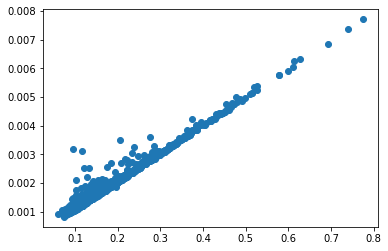

In [46]:
x = np.hstack(sig[:]).reshape(-1, 1)
y = np.hstack(new_target[:])
plt.scatter(x[:1000,0], y[:1000])
plt.show()

In [47]:
X = sm.add_constant(x)
model = sm.OLS(y*100,X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 7.708e+06
Date:                Tue, 19 Jul 2022   Prob (F-statistic):               0.00
Time:                        21:21:22   Log-Likelihood:             6.7408e+05
No. Observations:              274121   AIC:                        -1.348e+06
Df Residuals:                  274119   BIC:                        -1.348e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0261   7.79e-05    335.500      0.000       0.026       0.026
x1             0.9548      0.000   2776.254      0.000       0.954       0.955
==============================================================================
Omnibus:                   337921.075   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         66609629.204
Skew:                           6.641   Prob(JB):                         0.00
Kurtosis:                      78.203   Cond. No.                         9.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 特征相关性矩阵
- 计算相关系数矩阵
- 计算方差扩张系数

### 绝对价差
- 计算相关系数矩阵；
- 计算方差扩张系数；
- 使用scipy回归系数；
- 做检验；

In [8]:
# 绝对价差
se = SpreadEstimator(market='SP500')
univ = se.data.data_dic['volume'] > 0  # 合法的univ

data_path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"
univ = se.data.data_dic['volume'] > 0  # 合法的univ
with open(f'{data_path}/signal_spread.pkl', 'rb') as f:
    signal = pickle.load(f)
with open(f'{data_path}/target_spread.pkl', 'rb') as f:
    target = pickle.load(f)

x, y = get_train_data_cs(signal, target, univ, 20, 120)
xx = []
for x_ in x:
    for i in range(x_.shape[1]):
        x_[:, i] -= torch.nanmean(x_[:, i])
        x_[:, i] /= torch.std(x_[:, i])
    xx.append(x_)
x = xx

x_test_spread, y_test_spread = get_train_data_cs(signal, target, univ, 160, 200)
xx = []
for x_ in x_test_spread:
    for i in range(x_.shape[1]):
        x_[:, i] -= torch.nanmean(x_[:, i])
        x_[:, i] /= torch.std(x_[:, i])
        x_.cpu()
    xx.append(x_)
x_test_spread = xx

# 计算协方差矩阵
# corr_mat_spread = np.eye(9) * len(x)
# for i in tqdm(range(len(x))):
#     for j in range(8):
#         jj = [2, 1, 3, 4, 5, 0, 7, 10, 11][j]
#         for k in range(j+1, 9):
#             kk = [2, 1, 3, 4, 5, 0, 7, 10, 11][k]
#             a = x[i][:, jj].cpu().numpy()
#             b = x[i][:, kk].cpu().numpy()
#             a[np.isnan(a)] = 0
#             b[np.isnan(b)] = 0
#             corr = np.corrcoef(a, b)[0, 1]
#             if np.isnan(corr):
#                 corr = 0
            
#             corr_mat_spread[j, k] += corr
#             corr_mat_spread[k, j] += corr
# corr_mat_spread /= len(x)

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 8000.58it/s]


In [3]:
x_spread = np.vstack([xx.cpu().numpy() for xx in x])
y_spread = np.vstack([xx.cpu().numpy() for xx in y])

x_spread[np.isnan(x_spread)] = 0
x_spread = x_spread[:, [2, 1, 3, 4, 5, 0, 7, 10, 11]]

In [7]:
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\y_spread.pkl", 'wb') as f:
    pickle.dump(y_spread, f)

In [4]:
x_spread.shape

(48451, 9)

In [5]:
y_spread.shape

(48451, 1)

In [3]:
corr_mat_spread = np.eye(9) * len(x)
for i in tqdm(range(len(x))):
    for j in range(8):
        
        jj = [2, 1, 3, 4, 5, 0, 7, 10, 11][j]
        for k in range(j+1, 9):
            kk = [2, 1, 3, 4, 5, 0, 7, 10, 11][k]
            a = x[i][:, jj].cpu().numpy()
            b = x[i][:, kk].cpu().numpy()
            
            a[np.isnan(a)] = 0
            b[np.isnan(b)] = 0

            corr = np.mean(a * b) - np.mean(a)*np.mean(b)
            if np.isnan(corr):
                corr = 0
  
            corr_mat_spread[j, k] += corr
            corr_mat_spread[k, j] += corr

corr_mat_spread /= len(x)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 151.35it/s]


In [4]:
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\corr_mat_spread.pkl", 'wb') as f:
    pickle.dump(corr_mat_spread, f)

In [ ]:
x_spread = np.vstack([xx.cpu().numpy() for xx in x])
y_spread = np.vstack([xx.cpu().numpy() for xx in y])

x_spread[np.isnan(x_spread)] = 0
x_spread = x_spread[:, [2, 1, 3, 4, 5, 0, 7, 10, 11]]

# 奇异值分解
_, sigma, __ = np.linalg.svd(x_spread, full_matrices=False)
vif_spread = [variance_inflation_factor(x_spread, i) for i in range(x_spread.shape[1])]
# print(sigma)
print('cond: {:.4f}'.format(sigma[0]/sigma[-1]))
print('vif: ', vif_spread)
arg_spread = np.argsort(vif_spread)
print('vif arg: ', arg_spread)

### spread回归

In [ ]:
fea_names = np.array([ 'Roll', 'HL', 'LOT_X', 'LOT_Y', 'Gibbs', 'CHL', 'log_close', 'log_volume', 'log_cap'])

plt.figure(dpi=150)
plt.xticks(np.arange(len(fea_names)), labels=fea_names, 
                     rotation=45, rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(fea_names)), labels=fea_names)    


plt.imshow(corr_mat_spread)
plt.tight_layout()
plt.colorbar()
plt.show()


In [19]:
# fea_se = [0, 1, 2, 3, 4, 5, 7, 10, 11]
import sys
import numpy as np
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Windows11/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
import statsmodels.api as sm
import pickle

se = SpreadEstimator(market='SP500')
univ = (se.data.data_dic['volume'] > 0) & (se.data.spread_dic['spread']<5)

path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"
with open(f'{path}/signal_spread.pkl', 'rb') as f:
    signal = pickle.load(f)
    
with open(f'{path}/target_spread.pkl', 'rb') as f:
    y = pickle.load(f)
    
for i in range(signal.shape[0]):
    for j in range(signal.shape[2]):
        signal[i, univ[i], j] -= np.nanmean(signal[i, univ[i], j])
        signal[i, univ[i], j] /= np.nanstd(signal[i, univ[i], j])

signal[np.isnan(signal)] = 0
signal[np.isinf(signal)] = 0
    
x_spread = []
y_spread = []


for i in range(20,120):
    x_spread.append(signal[i, univ[i]])
    y_spread.append(y[i, univ[i]])

x_spread = np.vstack(x_spread)
y_spread = np.hstack(y_spread)

x_spread[np.isnan(x_spread)] = 0
x_spread = x_spread[:, [2, 1, 3, 4, 5, 0, 7, 10, 11]]

X = sm.add_constant(x_spread)
model = sm.OLS(y_spread,X)
res = model.fit()
res.summary()

C:\Users\Windows11\AppData\Local\Temp\ipykernel_49100\4208324173.py:26: RuntimeWarning: invalid value encountered in divide
  signal[i, univ[i], j] /= np.nanstd(signal[i, univ[i], j])
C:\Users\Windows11\AppData\Local\Temp\ipykernel_49100\4208324173.py:25: RuntimeWarning: invalid value encountered in subtract
  signal[i, univ[i], j] -= np.nanmean(signal[i, univ[i], j])
C:\Users\Windows11\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
C:\Users\Windows11\AppData\Local\Temp\ipykernel_49100\4208324173.py:25: RuntimeWarning: Mean of empty slice
  signal[i, univ[i], j] -= np.nanmean(signal[i, univ[i], j])
C:\Users\Windows11\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     6189.
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:05:43   Log-Likelihood:                -46301.
No. Observations:               46307   AIC:                         9.262e+04
Df Residuals:                   46297   BIC:                         9.271e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8000      0.003    261.736      0.000       0.794       0.806
x1             0.4676      0.005    100.317      0.000       0.458       0.477
x2             0.2935      0.005     64.341      0.000       0.285       0.302
x3             0.0030      0.003      0.888      0.374      -0.004       0.009
x4            -0.0761      0.003    -23.127      0.000      -0.083      -0.070
x5            -0.0028      0.003     -0.918      0.359      -0.009       0.003
x6            -0.0031      0.004     -0.834      0.404      -0.010       0.004
x7             0.0498      0.005      9.245      0.000       0.039       0.060
x8            -0.3506      0.093     -3.751      0.000      -0.534      -0.167
x9             0.3054      0.093      3.271      0.001       0.122       0.488
==============================================================================
Omnibus:                    60699.663   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28251042.992
Skew:                           7.076   Prob(JB):                         0.00
Kurtosis:                     123.173   Cond. No.                         63.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
res.params[1:]

array([ 0.46760631,  0.29353484,  0.0029519 , -0.07611347, -0.00280489,
       -0.00306924,  0.04977264, -0.35059419,  0.30540535])

In [18]:
_, sigma, __ = np.linalg.svd(x_spread, full_matrices=False)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_rela = [variance_inflation_factor(x_spread, i) for i in range(x_spread.shape[1])]
# print(sigma)
print('cond: {:.4f}'.format(sigma[0]/sigma[-1]))
print('vif: ', vif_rela)

arg_rela = np.argsort(vif_rela)
print('vif arg: ', arg_rela)

cond: 63.5786
vif:  [2.325680325859979, 2.2278141344136615, 1.1825814765027252, 1.1476918126305904, 1.0001224429308044, 1.449520788220888, 1.9304976850320295, 18.896864274022967, 18.866157094691946]
vif arg:  [4 3 2 5 6 1 0 8 7]


In [25]:
import matplotlib.pyplot as plt
fea_se = [0, 1, 2, 3, 4, 5, 7, 10, 11]
corr = [np.corrcoef(np.sum((x_test_spread[i].cpu().numpy()[:, [0, 1, 2, 3, 4, 5, 7, 10, 11]] * res.params[1:]),axis=1) + res.params[0],
             y_test_spread[i].cpu().numpy()[:,0])[0,1] for i in range(40)]

np.mean(corr)

0.8588716794499686

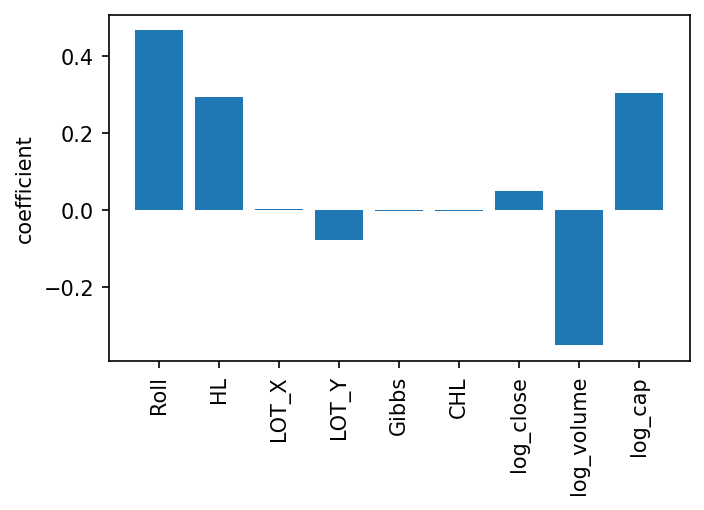

In [10]:
import matplotlib.pyplot as plt
fea_names = np.array([ 'Roll', 'HL', 'LOT_X', 'LOT_Y', 'Gibbs', 'CHL', 'log_close', 'log_volume', 'log_cap'])
plt.figure(figsize=(5,3),dpi=150)
plt.bar(fea_names, res.params[1:])
plt.xticks(rotation=90)
plt.ylabel('coefficient')

plt.show()

#### 相对价差

In [21]:
# fea_se = [0, 1, 2, 3, 4, 5, 7, 10, 11]
import sys
import numpy as np
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Windows11/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
import statsmodels.api as sm
import pickle

se = SpreadEstimator(market='SP500')
univ = (se.data.data_dic['volume'] > 0)

path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"
with open(f'{path}/signal_rela.pkl', 'rb') as f:
    signal = pickle.load(f)
    
with open(f'{path}/target_rela.pkl', 'rb') as f:
    y = pickle.load(f)
    
for i in range(signal.shape[0]):
    for j in range(signal.shape[2]):
        signal[i, univ[i], j] -= np.nanmean(signal[i, univ[i], j])
        signal[i, univ[i], j] /= np.nanstd(signal[i, univ[i], j])

signal[np.isnan(signal)] = 0
signal[np.isinf(signal)] = 0
    
x_spread = []
y_spread = []


for i in range(20,120):
    x_spread.append(signal[i, univ[i]])
    y_spread.append(y[i, univ[i]])

x_spread = np.vstack(x_spread)
y_spread = np.hstack(y_spread)

x_spread[np.isnan(x_spread)] = 0
x_spread = x_spread[:, [2, 1, 3, 4, 5, 0, 7, 10, 11]]

X = sm.add_constant(x_spread)
model = sm.OLS(y_spread*1e4,X)
res = model.fit()
res.summary()

C:\Users\Windows11\AppData\Local\Temp\ipykernel_49100\2548663957.py:26: RuntimeWarning: invalid value encountered in divide
  signal[i, univ[i], j] /= np.nanstd(signal[i, univ[i], j])
C:\Users\Windows11\AppData\Local\Temp\ipykernel_49100\2548663957.py:25: RuntimeWarning: invalid value encountered in subtract
  signal[i, univ[i], j] -= np.nanmean(signal[i, univ[i], j])
C:\Users\Windows11\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
C:\Users\Windows11\AppData\Local\Temp\ipykernel_49100\2548663957.py:25: RuntimeWarning: Mean of empty slice
  signal[i, univ[i], j] -= np.nanmean(signal[i, univ[i], j])
C:\Users\Windows11\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     841.5
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:06:38   Log-Likelihood:            -2.4938e+05
No. Observations:               48451   AIC:                         4.988e+05
Df Residuals:                   48441   BIC:                         4.989e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.9563      0.189    401.838      0.000      75.586      76.327
x1             7.8046      0.293     26.600      0.000       7.229       8.380
x2             2.9735      0.265     11.217      0.000       2.454       3.493
x3             0.3571      0.201      1.778      0.075      -0.037       0.751
x4            -0.4271      0.211     -2.026      0.043      -0.840      -0.014
x5             0.0780      0.189      0.413      0.680      -0.293       0.448
x6             1.3100      0.283      4.624      0.000       0.755       1.865
x7            22.5466      0.264     85.415      0.000      22.029      23.064
x8            -2.1948      6.058     -0.362      0.717     -14.068       9.678
x9            -5.4606      6.057     -0.902      0.367     -17.332       6.410
==============================================================================
Omnibus:                    18568.423   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101792.678
Skew:                           1.769   Prob(JB):                         0.00
Kurtosis:                       9.156   Cond. No.                         66.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
res.params[1:]

array([ 7.80456105,  2.97351481,  0.35710506, -0.42714941,  0.07797794,
        1.31000235, 22.54663268, -2.19484437, -5.46057858])

### rela vif

In [16]:
_, sigma, __ = np.linalg.svd(x_spread, full_matrices=False)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_rela = [variance_inflation_factor(x_spread, i) for i in range(x_spread.shape[1])]
# print(sigma)
print('cond: {:.4f}'.format(sigma[0]/sigma[-1]))
print('vif: ', vif_rela)

arg_rela = np.argsort(vif_rela)
print('vif arg: ', arg_rela)

cond: 66.1997
vif:  [1.4447003850360693, 1.9666463326861157, 1.1295047316462725, 1.232171384555907, 1.0001088499283772, 2.24616346710421, 1.2082692459069568, 20.476763011706524, 20.46927437008867]
vif arg:  [4 2 6 3 0 1 5 8 7]


In [8]:
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\corr_mat_rela.pkl", 'wb') as f:
    pickle.dump(corr_mat_rela, f)

In [9]:
x_rela = np.vstack([xx.cpu().numpy() for xx in x])
y_rela = np.vstack([xx.cpu().numpy() for xx in y])
x_rela[np.isnan(x_rela)] = 0
x_rela = x_rela[:, [2, 1, 3, 4, 5, 0, 7, 10, 11]]

In [12]:
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\x_rela.pkl", 'wb') as f:
    pickle.dump(x_rela, f)

In [17]:
x_rela = np.vstack([xx.cpu().numpy() for xx in x])
y_rela = np.vstack([xx.cpu().numpy() for xx in y])
x_rela[np.isnan(x_rela)] = 0
x_rela = x_rela[:, [0, 1, 2, 3, 4, 5, 7, 10, 11]]



# 奇异值分解
_, sigma, __ = np.linalg.svd(x_rela, full_matrices=False)
vif_rela = [variance_inflation_factor(x_rela, i) for i in range(x_rela.shape[1])]
# print(sigma)
print('cond: {:.4f}'.format(sigma[0]/sigma[-1]))
print('vif: ', vif_rela)

arg_rela = np.argsort(vif_rela)
print('vif arg: ', arg_rela)

cond: 2.7707
vif:  [1.6590122551932833, 1.5939166503575033, 1.0830626787422588, 1.2363127125679587, 1.0000200871687757, 1.9634756336478068, 1.5886893817505054, 1.4260439515418195, 1.6341012286233734]
vif arg:  [4 2 3 7 6 1 8 0 5]


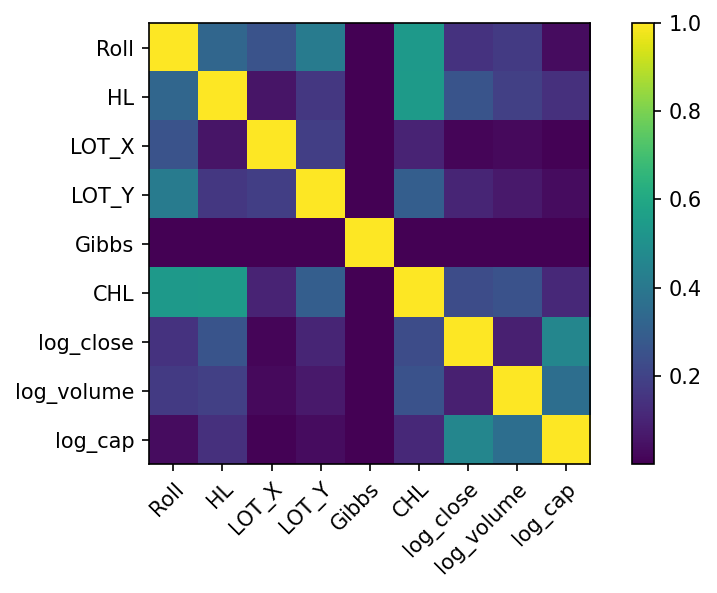

In [25]:
plt.figure(dpi=150)
plt.xticks(np.arange(len(fea_names)), labels=fea_names, 
                     rotation=45, rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(fea_names)), labels=fea_names)    


plt.imshow(np.abs(corr_mat_rela))
plt.tight_layout()
plt.colorbar()
plt.show()


In [28]:

X = sm.add_constant(x_rela)
model = sm.OLS(y_rela*10000,X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 2.591e+04
Date:                Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:59:47   Log-Likelihood:            -5.4924e+05
No. Observations:              216470   AIC:                         1.099e+06
Df Residuals:                  216460   BIC:                         1.099e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4307      0.007   1890.160      0.000      12.418      12.444
x1             0.0350      0.009      4.110      0.000       0.018       0.052
x2             0.1966      0.009     22.006      0.000       0.179       0.214
x3             0.1429      0.007     20.792      0.000       0.129       0.156
x4            -0.1151      0.007    -15.675      0.000      -0.129      -0.101
x5             0.0108      0.007      1.637      0.102      -0.002       0.024
x6            -0.2262      0.009    -24.539      0.000      -0.244      -0.208
x7            -2.5159      0.008   -303.410      0.000      -2.532      -2.500
x8            -0.8423      0.008   -107.217      0.000      -0.858      -0.827
x9            -0.8706      0.008   -103.523      0.000      -0.887      -0.854
==============================================================================
Omnibus:                    76313.015   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           526753.072
Skew:                           1.529   Prob(JB):                         0.00
Kurtosis:                      10.004   Cond. No.                         2.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
params = res.params.copy()
# params[[0,1,3,4,5]] *= -1
corr = [np.corrcoef(np.sum((x_test_rela[i].cpu().numpy() * params[1:]),axis=1) + res.params[0],
             y_test_rela[i].cpu().numpy()[:,0])[0,1] for i in range(80)]
np.mean(corr)

0.10253923515813265

In [115]:
params = res.params.copy()
np.corrcoef(np.sum((x_rela * params[1:]),axis=1) + res.params[0],y_rela[:,0])

array([[1.        , 0.62979848],
       [0.62979848, 1.        ]])

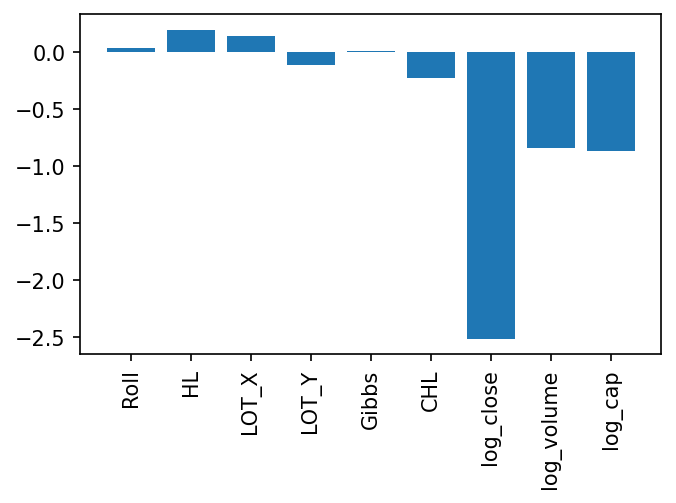

In [29]:
plt.figure(figsize=(5,3),dpi=150)
tmp = res.params[1:]

plt.bar(np.array(fea_names), tmp)
plt.xticks(rotation=90)

plt.show()